### Loading Data on Google Colab from Google Drive

In [1]:
!cp -r "/content/drive/My Drive/Colab Notebooks/Intel Image Classification.zip" "/content/"

In [ ]:
!unzip 'Intel Image Classification.zip'

Dataset Downloaded from Kaggle Link:- https://www.kaggle.com/puneet6060/intel-image-classification

### Enabling and testing the TPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

### Importing Libraries

In [3]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.7.0
Found GPU at: /device:GPU:0


In [17]:
# additional imports

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sn
from tensorflow.keras.preprocessing import image


### Data Augmentation & Data Loading

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
training_set = train_datagen.flow_from_directory('/content/Intel Image Classification/seg_train/seg_train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode='categorical')

Found 14034 images belonging to 6 classes.


In [7]:
test_set = test_datagen.flow_from_directory('/content/Intel Image Classification/seg_test/seg_test',
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            shuffle=False,
                                            class_mode='categorical')

Found 3000 images belonging to 6 classes.


### Model_1

In [8]:
i = Input(shape=(150,150, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

#x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(6, activation='softmax')(x)

model = Model(i, x)


### Model Compailation and Model Fitting

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [10]:
r = model.fit(training_set,
                  epochs = 50,
                  validation_data = test_set)

Epoch 1/50
439/439 [==============================] - 173s 356ms/step - loss: 6.6382 - accuracy: 0.4781 - val_loss: 2.5153 - val_accuracy: 0.4087
Epoch 2/50
439/439 [==============================] - 151s 344ms/step - loss: 1.1668 - accuracy: 0.5622 - val_loss: 1.2041 - val_accuracy: 0.5680
Epoch 3/50
439/439 [==============================] - 151s 344ms/step - loss: 1.0425 - accuracy: 0.6062 - val_loss: 0.8058 - val_accuracy: 0.6883
Epoch 4/50
439/439 [==============================] - 151s 344ms/step - loss: 0.9591 - accuracy: 0.6436 - val_loss: 0.7609 - val_accuracy: 0.7197
Epoch 5/50
439/439 [==============================] - 151s 344ms/step - loss: 0.9206 - accuracy: 0.6669 - val_loss: 0.7557 - val_accuracy: 0.7247
Epoch 6/50
439/439 [==============================] - 151s 344ms/step - loss: 0.8659 - accuracy: 0.6877 - val_loss: 0.7005 - val_accuracy: 0.7477
Epoch 7/50
439/439 [==============================] - 151s 344ms/step - loss: 0.8190 - accuracy: 0.7066 - val_loss: 0.7569 -

### Train on the TPU

In [ ]:
with tpu_strategy.scope():
  model = create_model()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])

r = model.fit(training_set,
              epochs = 50,
              validation_data = test_set)


### Loss and Accuracy Graph

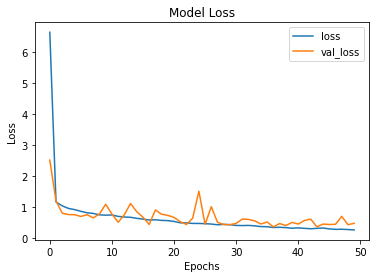

In [11]:
# Plot what's returned by model.fit() / model.fit_generator()
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

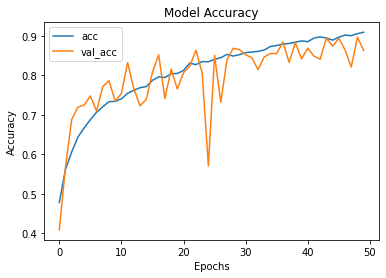

In [12]:
##### Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

### Model Saving and Model Summary

In [13]:
# Saving Trained Model
model.save('Intel Image Classification.h5') # creates a HDF5 file
#for TPU
#model.save_weights('./fashion_mnist.h5', overwrite=True)

In [14]:
#Loading previously trained model

#from keras.models import load_model
#classifier = load_model('cats_and_dogs.h5')

model= tf.keras.models.load_model('Intel Image Classification.h5')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0     

### Single Prediction Check

In [20]:
model=tf.keras.models.load_model('Intel Image Classification.h5')
img=image.load_img('/content/Intel Image Classification/seg_pred/seg_pred/10572.jpg',target_size=(150,150))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
#img_data=preprocess_input(x)
#img_data.shape
model.predict(x)
a=np.argmax(model.predict(x), axis=1)
if a == 0:
    print("buildings")
elif a == 1:
    print("forest")
elif a == 2:
    print("glacier")
elif a == 3:
    print("moutain")
elif a == 4:
    print("sea")
else:
    print("street")

buildings


## F1 Score and Confusion Matrix

In [21]:
predictions = model.predict(test_set).round(3)

#predicted_classes = [1 * (x[0]>=0.5) for x in predictions]

predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes)

[0 0 0 ... 4 5 5]


In [22]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

#print(true_classes)
#print(class_labels)

In [23]:
print(classification_report(true_classes, predicted_classes, target_names=class_labels))   #target_names = ['dense_traffic (Class 0)','sparse_traffic (Class 1)']))

              precision    recall  f1-score   support

   buildings       0.86      0.88      0.87       437
      forest       0.97      0.98      0.97       474
     glacier       0.86      0.70      0.77       553
    mountain       0.71      0.88      0.79       525
         sea       0.92      0.83      0.87       510
      street       0.91      0.92      0.92       501

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.86      0.86      3000



In [24]:
print(training_set.class_indices) 

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


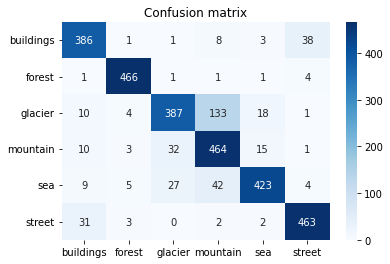

In [25]:
class_names = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street']

CM = confusion_matrix(true_classes, predicted_classes)

ax = plt.axes()
sn.heatmap(CM, annot=True, 
           cmap= "Blues", 
           annot_kws={"size": 10},
            fmt='', 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()